# **Finding the Right Starting Point: How Weight Initialization Acts as the GPS of Deep Learning**

Before a neural network takes its first step toward learning — before it recognizes a digit, a shape, a cat, or a face — it begins with a single question:

**“Where am I on this landscape?”**

The answer to that question comes from
***weight initialization***, <br>
the very first coordinates your model is given.

If those coordinates are good, training becomes a smooth, confident journey. <br>
If they’re bad… your model wanders, gets lost, or never moves at all.

This is the story of how weight initialization shapes everything.

![Alt Text](../Laboratories/assets/weight1.png)

## **The Landscape and the Traveler**

Imagine the loss surface — mountains, valleys, cliffs, flat deserts.

Your **model** is the *traveler*. <br>
**Gradient descent** is its *compass*.<br>
**Optimization** is the *journey*. <br>
And **weight initialization** is the *starting location*.

Start too high → the traveler slides uncontrollably (exploding gradients) <br>
Start too low → everything looks flat (vanishing gradients) <br>
Start at the same point → everyone takes the same path (symmetry) <br>
Start at a good spot → good gradients, good learning, good destination <br>

Initialization looks tiny in code… but in practice, it creates the entire world your model begins in.

## **What Weight Initialization Actually Does**

**What is weight initialization?**

According to Analytics Vidhya, weight initialization refers to how we assign the first values to a neural network’s weights before training begins. These initial values influence how easily gradients can flow through the network. Choosing the right initialization technique helps the model start in a balanced state so it can learn efficiently from the very first step.

Deep networks repeatedly transform signals through layers.
To train well, signals must flow stably. This depends on three things:

1. `fan_in`

> How many inputs a neuron receives.

2. `fan_out`

> How many outputs it sends to the next layer.

3. `Activation function`

> Controls how much the neuron “squishes” or “clips” information.

Initialization formulas set the variance of weights based on these three, ensuring activations don’t explode, gradients don’t disappear, and all neurons learn differently.

## **Choosing the Right GPS Coordinates: Criteria For Initialization**

As we learned in the previous section, weight initialization sets the traveler’s **starting location** on the loss landscape, ensuring signals flow stably through the network. But how do we decide where exactly to start? Here are the key criteria, building on what we already know about `fan_in`, `fan_out`, and activation functions:


**1. Activation Function — How the Compass Behaves**

* Different activations transform signals differently, like compasses that respond uniquely to terrain.
* A poor match between starting location and activation can cause:

  * **Vanishing gradients** → tiny steps, slow learning
  * **Exploding gradients** → sliding down cliffs, unstable training
* Activation function remains the **most important factor** in choosing a starting point. Proper alignment between activation function and initialization prevents gradient issues and ensures the model converges faster and learns more efficiently from the first steps.

**2. Model Depth — Length of the Journey**

* Deep networks are like long, multi-stage hikes.
* Small instabilities at the start amplify over layers.
* Proper initialization keeps signals stable across layers, preventing vanishing/exploding gradients and improving training stability and final performance.

**3. Layer Size (fan_in / fan_out) — Width of the Trail**

* Wide layers → signals may become too strong, causing overshooting.
* Narrow layers → signals may be too weak, causing slow movement.
* Scaling weights according to layer size ensures consistent variance of activations, helping the model converge reliably and avoid divergence during training.Initialization formulas already take these into account, balancing the scale of weights so the traveler maintains control throughout the journey.

**4. Dataset Size — Not Part of the Starting Point**

* Unlike training parameters or batch size, the dataset size doesn’t determine where the traveler begins.
* Choosing the starting location is about **internal signal stability**, not the number of training examples.

**5. Architecture — Different Terrains Require Different Starting Locations**

* Different models represent different terrains:

  * **CNNs** → structured, grid-like paths
  * **MLPs** → broad open fields
  * **RNNs / LSTMs** → winding paths with memory
  * **Transformers** → multi-directional landscapes
* The traveler’s starting point should suit the model’s landscape to ensure stable gradient flow, better generalization, and fewer training difficulties.


***Note:*** Most of these criteria are already reflected in the formulas we use for initialization, which automatically scale weights based on `fan_in`, `fan_out`, and activation type. The next section will introduce the main initialization algorithms — the GPS tools that place the traveler optimally on the map.


## **The Main Initialization Methods And What Terrain They Create**

Choosing a weight initialization method is like picking the terrain where your traveler begins the journey. Different starting points create very different paths — some easy, some treacherous. Let’s explore the main methods:

**1. Zero Initialization — Flat, Boring Plateau**

Imagine placing every traveler at the exact same spot on the map, giving them identical compasses. In this scenario, every traveler would follow the same path, never exploring new routes.

In neural networks, **zero initialization** works similarly: all neurons in a layer are assigned a weight of zero. This means every neuron receives identical gradients during backpropagation and updates in the same way, preventing them from learning unique features. According to Analytics Vidhya and Piyush Kashyap (Medium), this **“symmetry problem”** means all neurons learn the same thing, so the network cannot improve and stops learning right from the start.

**2. Small Random Numbers — Tiny Hills or Steep Cliffs**

Imagine letting the traveler start anywhere randomly — they might end up in quicksand, tiny hills, or steep cliffs.

If we compare this to **Zero Initialization**, which placed every traveler at the exact same spot (all neurons identical), small random numbers do solve the **symmetry problem**: now each traveler (neuron) starts at a slightly different point and can explore different paths.

However, according to **Analytics Vidhya** and **Piyush Kashyap (Medium)**, the scale of these random values is critical:

* **Too small values** → gradients vanish, like walking on flat plains, making learning very slow.
* **Moderate values** → gradients are usable, but still may be unstable without careful scaling.
* **Too large values** → gradients explode, like sliding down a cliff uncontrollably, making training unstable.

**Why it is still not advisable:** While small random initialization breaks symmetry and allows neurons to learn differently, it does **not provide any mathematical guarantee** to keep gradients stable across layers. For deep networks, this can lead to **slow convergence or divergence**, which is why methods like **Xavier** and **He** are preferred—they systematically scale weights according to the layer size and activation function to create **safe and balanced terrain** for the traveler from the very start.

**3. Xavier (Glorot) Initialization — Balanced Plateau**

Imagine placing the traveler on a smooth, well-leveled plateau — easy to explore in all directions. Compared to Small Random Numbers, this starting point is carefully calculated, not left to chance.

**Xavier initialization** assigns weights based on the number of inputs (`fan_in`) and outputs (`fan_out`) of a layer to maintain **stable signal variance**. This prevents the traveler from getting stuck in flat regions (vanishing gradients) or sliding down cliffs (exploding gradients).

* **Uniform distribution formula:** <br>
  $
  W \sim \mathcal{U}\Big(-\sqrt{\frac{6}{fan_{in} + fan_{out}}}, \sqrt{\frac{6}{fan_{in} + fan_{out}}}\Big)
  $
<br>

* **Variance for normal distribution:** <br>
  $
  Var(W) = \frac{2}{fan_{in} + fan_{out}}
  $

According to **Analytics Vidhya** and **Piyush Kashyap (Medium)**, Xavier works best with **tanh** or **sigmoid** activations. By scaling weights mathematically, it creates **balanced terrain**, allowing the traveler to move steadily without the risks posed by unscaled random weights.


**4. He (Kaiming) Initialization — Energizing Downhill**

Now imagine the traveler starting on a gentle downhill slope — enough momentum to overcome obstacles but not so steep that they lose control. Compared to Xavier, He initialization gives the traveler **extra energy**, which is necessary for ReLU activations that zero out negative signals.

**He initialization** sets the variance based on the number of inputs (`fan_in`) only, compensating for ReLU’s tendency to “kill” half the neurons:

$
W \sim \mathcal{N}\Big(0, \sqrt{\frac{2}{fan_{in}}}\Big)
$

**Why it works:** This energizing starting point ensures gradients remain strong throughout the journey, helping the network converge faster and more reliably. Analytics Vidhya and Piyush Kashyap (Medium) note that He initialization is the standard for **deep ReLU networks**, because it overcomes the limitations of small random numbers while maintaining stable learning.


> **Summary & Comparison:**
>
> * **Zero Initialization:** All neurons identical → no learning.
> * **Small Random Numbers:** Breaks symmetry but may create dangerous terrain (vanishing/exploding gradients).
> * **Xavier:** Mathematically balances variance → smooth plateau for tanh/sigmoid activations.
> * **He:** Provides extra “energy” for ReLU → gentle downhill, safe, fast, and stable.

Choosing the right initialization is like choosing the right **terrain for the traveler**: safe, balanced, and suited to the type of journey (activation function and architecture) ensures the model learns efficiently from the very first step.





## **5. Experiment: CNN on MNIST With Different Initializations**

We train a simple CNN on MNIST using:

* Zero initialization
* Too-small initialization
* Too-large initialization
* Incorrect Xavier initialization with ReLU
* Correct He initialization (paired with ReLU)

We analyze accuracy, loss curves, and training time.

Here, we focus specifically on how initialization interacts with the network’s activation, which acts like the model’s “compass” guiding the learning journey. 

By exploring these combinations, we will see, epoch by epoch, which strategies allow the model to navigate efficiently, avoid obstacles, and reach its destination successfully.

### **CNN Model (ReLU-based)**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

In [ ]:
# CNN Architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # Corrected the input features for fc1 from 64*7*7 to 64*14*14
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2) # This pooling reduces 28x28 to 14x14
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### **Initialization Variants We Tested**

#### **Zero initialization**

In [3]:
def init_zero(m):
    if hasattr(m, "weight"):
        nn.init.constant_(m.weight, 0.0)

#### **Too-small weights**

In [4]:
def init_too_small(m):
    if hasattr(m, "weight"):
        nn.init.normal_(m.weight, mean=0.0, std=0.00001)

#### **Too-large weights**

In [5]:
def init_too_large(m):
    if hasattr(m, "weight"):
        nn.init.normal_(m.weight, mean=0.0, std=10.0)


#### **Incorrect ReLU initializer (Xavier)**

In [7]:
def init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)


#### **Correct ReLU initializer (He)**

In [6]:
def init_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")


### **Training Loop**

The training loop runs for 20 epochs, processing all MNIST training images in batches of 64. For each batch, the CNN performs a forward pass to compute predictions, calculates the cross-entropy loss, backpropagates the gradients, and updates the weights using the Adam optimizer with a learning rate of 0.001. After each epoch, the average loss, training accuracy, and epoch duration are recorded. Once training is complete, the model is evaluated on the test set to measure final loss and accuracy. The choice of 20 epochs strikes a balance between giving the model enough time to converge and keeping the experiments efficient for multiple initialization variants. Importantly, this entire setup — including batch size, number of epochs, learning rate, optimizer, and evaluation procedure — is kept identical across all initialization methods, ensuring that any differences in training behavior or final performance can be attributed solely to the weight initialization.

In [9]:
def train_model(initializer, title):
    model = CNN()
    model.apply(initializer)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    transform = transforms.Compose([transforms.ToTensor()])

    # Training data
    train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

    # Test / Holdout data
    test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

    train_losses, train_accuracies = [], []
    epoch_times = []

    print(f"\n=== Training with {title} Initialization ===")

    total_start = time.time()

    # Training loop with tqdm
    for epoch in range(20):
        model.train()
        total, correct = 0, 0
        epoch_loss = 0

        epoch_start = time.time()
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/20", leave=False)

        for images, labels in pbar:
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Store results
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Save epoch time
        epoch_times.append(time.time() - epoch_start)

        print(f"{title} | Epoch {epoch+1:02d}: Loss={train_losses[-1]:.4f}, Acc={train_accuracies[-1]:.2f}%")

    # ------- Training Time Summary -------
    total_training_time = time.time() - total_start
    avg_epoch_time = sum(epoch_times) / len(epoch_times)

    print(f"\nTotal Training Time for {title}: {total_training_time:.2f} seconds")
    print(f"Average Time per Epoch across 20 epochs: {avg_epoch_time:.2f} seconds\n")

    # ------- Evaluate on Test Set -------
    model.eval()
    total_test, correct_test = 0, 0
    test_loss = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    print(f"{title} | Test Set Results → Loss={test_loss:.4f}, Acc={test_accuracy:.2f}%")

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "total_train_time": total_training_time,
        "avg_epoch_time": avg_epoch_time
    }


### **Run All Initializers**

In [10]:
inits = {
    "Zero Initialization": init_zero,
    "Too Small Random": init_too_small,
    "Too Large Random": init_too_large,
    "Xavier Init (Incorrect for ReLU)": init_xavier,
    "He Init (Correct for ReLU)": init_he
}

results = {}

for name, initializer_fn in inits.items(): 
    metrics = train_model(initializer_fn, name)

    # Store everything returned by train_model
    results[name] = metrics



=== Training with Zero Initialization Initialization ===


Zero Initialization | Epoch 01: Loss=2.3019, Acc=10.88%


Zero Initialization | Epoch 02: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 03: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 04: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 05: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 06: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 07: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 08: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 09: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 10: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 11: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 12: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 13: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 14: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 15: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 16: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 17: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 18: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 19: Loss=2.3013, Acc=11.24%


Zero Initialization | Epoch 20: Loss=2.3013, Acc=11.24%

Total Training Time for Zero Initialization: 2646.81 seconds
Average Time per Epoch across 20 epochs: 132.34 seconds

Zero Initialization | Test Set Results → Loss=2.3010, Acc=11.35%

=== Training with Too Small Random Initialization ===


Too Small Random | Epoch 01: Loss=1.4595, Acc=44.32%


Too Small Random | Epoch 02: Loss=0.8374, Acc=72.61%


Too Small Random | Epoch 03: Loss=0.7495, Acc=75.88%


Too Small Random | Epoch 04: Loss=0.7110, Acc=77.28%


Too Small Random | Epoch 05: Loss=0.6852, Acc=78.26%


Too Small Random | Epoch 06: Loss=0.6538, Acc=79.67%


Too Small Random | Epoch 07: Loss=0.6107, Acc=81.33%


Too Small Random | Epoch 08: Loss=0.5657, Acc=82.94%


Too Small Random | Epoch 09: Loss=0.5196, Acc=84.63%


Too Small Random | Epoch 10: Loss=0.4681, Acc=86.51%


Too Small Random | Epoch 11: Loss=0.4188, Acc=88.15%


Too Small Random | Epoch 12: Loss=0.3718, Acc=89.58%


Too Small Random | Epoch 13: Loss=0.3354, Acc=90.51%


Too Small Random | Epoch 14: Loss=0.3026, Acc=91.49%


Too Small Random | Epoch 15: Loss=0.2760, Acc=92.27%


Too Small Random | Epoch 16: Loss=0.2561, Acc=92.89%


Too Small Random | Epoch 17: Loss=0.2359, Acc=93.39%


Too Small Random | Epoch 18: Loss=0.2200, Acc=93.73%


Too Small Random | Epoch 19: Loss=0.2066, Acc=94.13%


Too Small Random | Epoch 20: Loss=0.1943, Acc=94.51%

Total Training Time for Too Small Random: 2608.37 seconds
Average Time per Epoch across 20 epochs: 130.42 seconds

Too Small Random | Test Set Results → Loss=0.2159, Acc=94.13%

=== Training with Too Large Random Initialization ===


Too Large Random | Epoch 01: Loss=29122366.4883, Acc=41.50%


Too Large Random | Epoch 02: Loss=5467828.1679, Acc=75.88%


Too Large Random | Epoch 03: Loss=3221399.4090, Acc=83.73%


Too Large Random | Epoch 04: Loss=2321597.6870, Acc=87.23%


Too Large Random | Epoch 05: Loss=1800853.2323, Acc=89.24%


Too Large Random | Epoch 06: Loss=1443566.5291, Acc=90.61%


Too Large Random | Epoch 07: Loss=1183701.5909, Acc=91.70%


Too Large Random | Epoch 08: Loss=993625.6257, Acc=92.62%


Too Large Random | Epoch 09: Loss=849425.3498, Acc=93.33%


Too Large Random | Epoch 10: Loss=735308.2706, Acc=93.95%


Too Large Random | Epoch 11: Loss=643847.8696, Acc=94.42%


Too Large Random | Epoch 12: Loss=564434.8323, Acc=94.89%


Too Large Random | Epoch 13: Loss=500421.5892, Acc=95.21%


Too Large Random | Epoch 14: Loss=439188.3642, Acc=95.64%


Too Large Random | Epoch 15: Loss=390283.8316, Acc=95.98%


Too Large Random | Epoch 16: Loss=348779.3642, Acc=96.20%


Too Large Random | Epoch 17: Loss=311827.7319, Acc=96.52%


Too Large Random | Epoch 18: Loss=278175.1299, Acc=96.76%


Too Large Random | Epoch 19: Loss=248491.8648, Acc=97.01%


Too Large Random | Epoch 20: Loss=223224.0932, Acc=97.25%

Total Training Time for Too Large Random: 2637.08 seconds
Average Time per Epoch across 20 epochs: 131.85 seconds

Too Large Random | Test Set Results → Loss=533112.1803, Acc=95.14%

=== Training with Xavier Init (Incorrect for ReLU) Initialization ===


Xavier Init (Incorrect for ReLU) | Epoch 01: Loss=0.1695, Acc=94.90%


Xavier Init (Incorrect for ReLU) | Epoch 02: Loss=0.0475, Acc=98.59%


Xavier Init (Incorrect for ReLU) | Epoch 03: Loss=0.0313, Acc=98.98%


Xavier Init (Incorrect for ReLU) | Epoch 04: Loss=0.0215, Acc=99.32%


Xavier Init (Incorrect for ReLU) | Epoch 05: Loss=0.0169, Acc=99.43%


Xavier Init (Incorrect for ReLU) | Epoch 06: Loss=0.0111, Acc=99.63%


Xavier Init (Incorrect for ReLU) | Epoch 07: Loss=0.0099, Acc=99.66%


Xavier Init (Incorrect for ReLU) | Epoch 08: Loss=0.0090, Acc=99.67%


Xavier Init (Incorrect for ReLU) | Epoch 09: Loss=0.0075, Acc=99.74%


Xavier Init (Incorrect for ReLU) | Epoch 10: Loss=0.0059, Acc=99.81%


Xavier Init (Incorrect for ReLU) | Epoch 11: Loss=0.0051, Acc=99.82%


Xavier Init (Incorrect for ReLU) | Epoch 12: Loss=0.0051, Acc=99.81%


Xavier Init (Incorrect for ReLU) | Epoch 13: Loss=0.0036, Acc=99.89%


Xavier Init (Incorrect for ReLU) | Epoch 14: Loss=0.0038, Acc=99.87%


Xavier Init (Incorrect for ReLU) | Epoch 15: Loss=0.0024, Acc=99.92%


Xavier Init (Incorrect for ReLU) | Epoch 16: Loss=0.0041, Acc=99.89%


Xavier Init (Incorrect for ReLU) | Epoch 17: Loss=0.0039, Acc=99.86%


Xavier Init (Incorrect for ReLU) | Epoch 18: Loss=0.0020, Acc=99.94%


Xavier Init (Incorrect for ReLU) | Epoch 19: Loss=0.0035, Acc=99.89%


Xavier Init (Incorrect for ReLU) | Epoch 20: Loss=0.0033, Acc=99.89%

Total Training Time for Xavier Init (Incorrect for ReLU): 2075.68 seconds
Average Time per Epoch across 20 epochs: 103.78 seconds

Xavier Init (Incorrect for ReLU) | Test Set Results → Loss=0.0496, Acc=99.04%

=== Training with He Init (Correct for ReLU) Initialization ===


He Init (Correct for ReLU) | Epoch 01: Loss=0.1322, Acc=95.95%


He Init (Correct for ReLU) | Epoch 02: Loss=0.0355, Acc=98.88%


He Init (Correct for ReLU) | Epoch 03: Loss=0.0214, Acc=99.35%


He Init (Correct for ReLU) | Epoch 04: Loss=0.0140, Acc=99.54%


He Init (Correct for ReLU) | Epoch 05: Loss=0.0098, Acc=99.66%


He Init (Correct for ReLU) | Epoch 06: Loss=0.0087, Acc=99.71%


He Init (Correct for ReLU) | Epoch 07: Loss=0.0060, Acc=99.80%


He Init (Correct for ReLU) | Epoch 08: Loss=0.0066, Acc=99.79%


He Init (Correct for ReLU) | Epoch 09: Loss=0.0055, Acc=99.83%


He Init (Correct for ReLU) | Epoch 10: Loss=0.0040, Acc=99.87%


He Init (Correct for ReLU) | Epoch 11: Loss=0.0046, Acc=99.86%


He Init (Correct for ReLU) | Epoch 12: Loss=0.0033, Acc=99.89%


He Init (Correct for ReLU) | Epoch 13: Loss=0.0044, Acc=99.88%


He Init (Correct for ReLU) | Epoch 14: Loss=0.0020, Acc=99.94%


He Init (Correct for ReLU) | Epoch 15: Loss=0.0025, Acc=99.91%


He Init (Correct for ReLU) | Epoch 16: Loss=0.0029, Acc=99.91%


He Init (Correct for ReLU) | Epoch 17: Loss=0.0024, Acc=99.93%


He Init (Correct for ReLU) | Epoch 18: Loss=0.0022, Acc=99.92%


He Init (Correct for ReLU) | Epoch 19: Loss=0.0040, Acc=99.89%


He Init (Correct for ReLU) | Epoch 20: Loss=0.0026, Acc=99.92%

Total Training Time for He Init (Correct for ReLU): 1920.69 seconds
Average Time per Epoch across 20 epochs: 96.03 seconds

He Init (Correct for ReLU) | Test Set Results → Loss=0.0605, Acc=99.00%


### **Plotting Accuracy and Loss**

The `plot_initialization_results()` function visualizes model performance across different initialization variants by generating a dual-axis plot for each variant. It displays training loss over epochs on the left y-axis and training accuracy on the right y-axis, allowing both metrics to be viewed simultaneously. The function also highlights the final test accuracy with a red marker to clearly show the model’s generalization performance. The average epoch time is included in the plot title to provide additional insight into training efficiency. This visualization helps compare how different initialization strategies affect convergence behavior, training stability, and final accuracy which are discussed in the next section.

In [ ]:
def plot_initialization_results(results_dict, variants_to_plot=None):
    if variants_to_plot is None:
        variants_to_plot = list(results_dict.keys())

    for variant in variants_to_plot:

        data = results_dict[variant]

        train_losses = data["train_losses"]
        train_accuracies = data["train_accuracies"]
        test_accuracy = data["test_accuracy"]
        avg_epoch_time = data.get("avg_epoch_time", None)

        epochs = range(1, len(train_losses) + 1)

        plt.figure(figsize=(10, 6))

        # === Training Loss (left y-axis, BLUE) ===
        ax1 = plt.gca()
        ax1.plot(
            epochs,
            train_losses,
            label="Training Loss",
            color="tab:blue",
            marker='o'
        )
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("Loss", color="tab:blue")
        ax1.tick_params(axis='y', labelcolor="tab:blue")
        ax1.grid(True)

        # === Training Accuracy (right y-axis, ORANGE) ===
        ax2 = ax1.twinx()
        ax2.plot(
            epochs,
            train_accuracies,
            label="Training Accuracy",
            color="tab:orange",
            marker='s',
            linestyle='--'
        )
        ax2.scatter(
            len(train_accuracies),
            test_accuracy,
            s=130,
            color="red",
            label="Test Accuracy",
            zorder=5
        )
        ax2.set_ylabel("Accuracy (%)", color="tab:orange")
        ax2.tick_params(axis='y', labelcolor="tab:orange")

        # === Combine legends from both axes ===
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc="center right")

        # === Title with optional avg epoch time ===
        if avg_epoch_time:
            plt.title(f"{variant}  |  Avg Epoch Time: {avg_epoch_time:.2f} sec")
        else:
            plt.title(variant)

        plt.tight_layout()
        plt.show()


## **Results: How the Traveler’s Journey Changed**


Again, think of a neural network as a traveler embarking on a long journey across MNIST dataset. The starting terrain—the weight initialization—determines how easy or treacherous the path will be. Let’s explore the journeys of travelers under different initializations and what actually happened during training.

### **Zero Initialization — Stuck on the Flat Plateau**

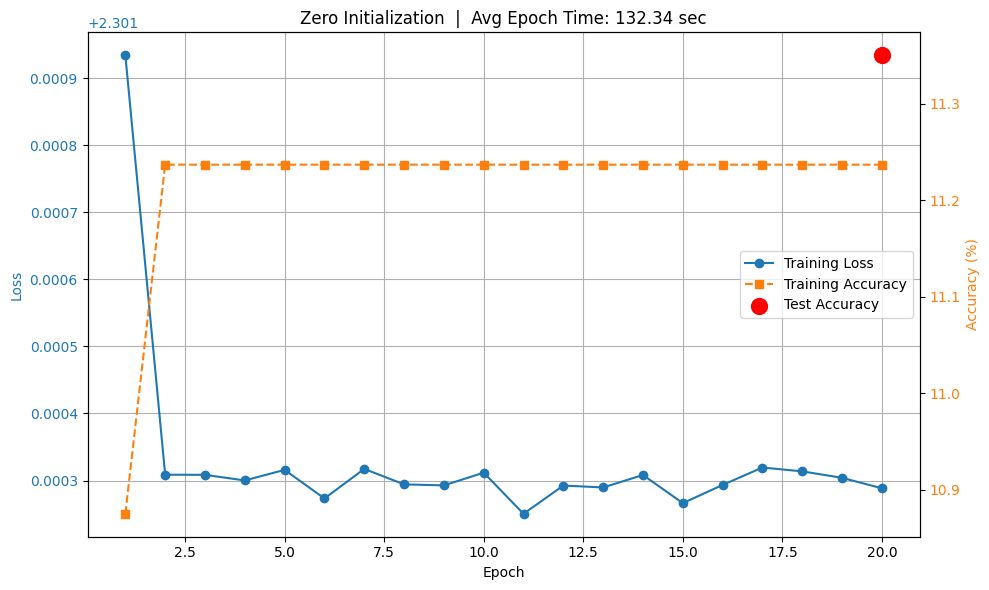

In [24]:
plot_initialization_results(
    results,
    variants_to_plot=["Zero Initialization"]
)

The phenomenon of **Zero Initialization** is perfectly captured by the analogy: **it is like placing all travelers at the exact same spot on a completely flat plateau, each with identical compasses, meaning they can’t choose different paths because all instructions are the same.** The plot results confirm this failure to break symmetry: throughout **20 epochs** and **2646 seconds** of training, the **Training Loss** (blue solid line) barely decreased from 2.302 to 2.301. Visually, this is represented by a **strictly horizontal line at 2.30**, demonstrating the network's inability to minimize error and descend the loss landscape. Similarly, the **Training Accuracy** (orange dashed line) remained stagnant at around **11%**, the level of random guessing (likely for 10 classes). All neurons received identical gradients, so **no neuron learned unique features**, confirming the claim that the network "stood still." This complete lack of progress is further evidenced by the poor generalization, as the **Test Accuracy** (red marker) also settled at a low **11.35%**, showing the traveler never truly left the starting plateau.

### **Too Small Random Initialization — Tiptoeing on Tiny Hills**

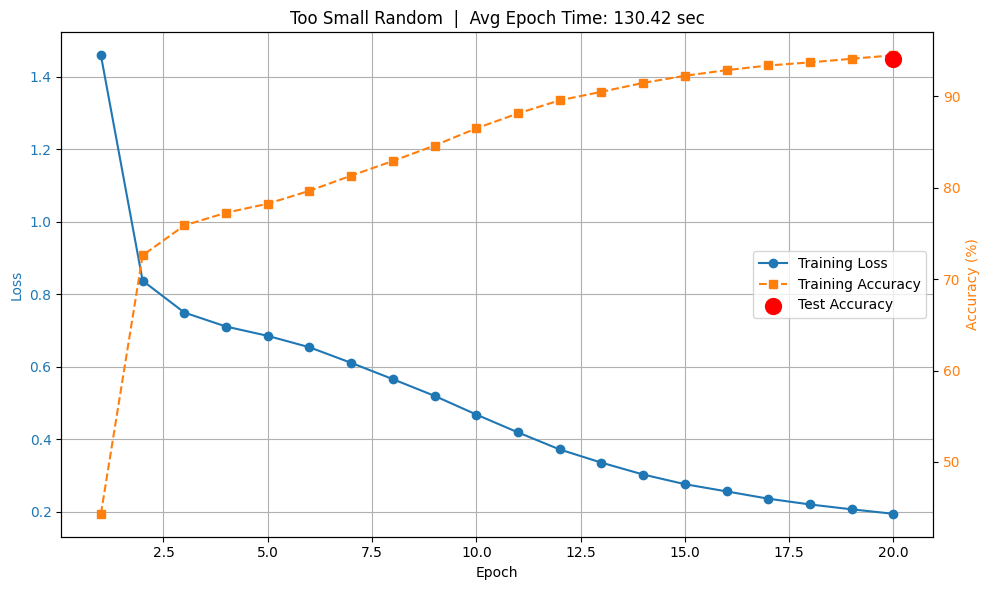

In [25]:
plot_initialization_results(
    results,
    variants_to_plot=["Too Small Random"]
)

Using very small random weights is perfectly illustrated as **it is like putting the traveler on tiny hills, where they can explore, but every step is cautious and slow.** The plot confirms this **cautious but steady** progression, avoiding the symmetry problem seen in zero initialization. The network started improving quickly, which is visually demonstrated by the **Training Accuracy** (orange dashed line) soaring immediately from near zero to **78% by epoch 5**. Correspondingly, the **Training Loss** (blue solid line) dropped sharply from 1.46 to 0.68, staying very close to the x-axis, confirming that the loss is being minimized effectively. The progress continued steadily, reaching **86.5% accuracy by epoch 10**, with the accuracy curve showing a gentle, sustained upward trend rather than a sharp jump, demonstrating gradual learning. The training process continued until epoch 20, where the training accuracy reached a high of **94.5%**. Crucially, the **Test Accuracy** (red marker at 94.13%) tracks the training accuracy closely, confirming that the weak, non-zero gradients allowed for **reliable learning and excellent generalization**. This scenario shows a journey that was safe but not optimal for speed, resulting in slow learning but reliable results, as the traveler tiptoes forward.

### **Too Large Random Initialization — Sliding Down Steep Cliffs**

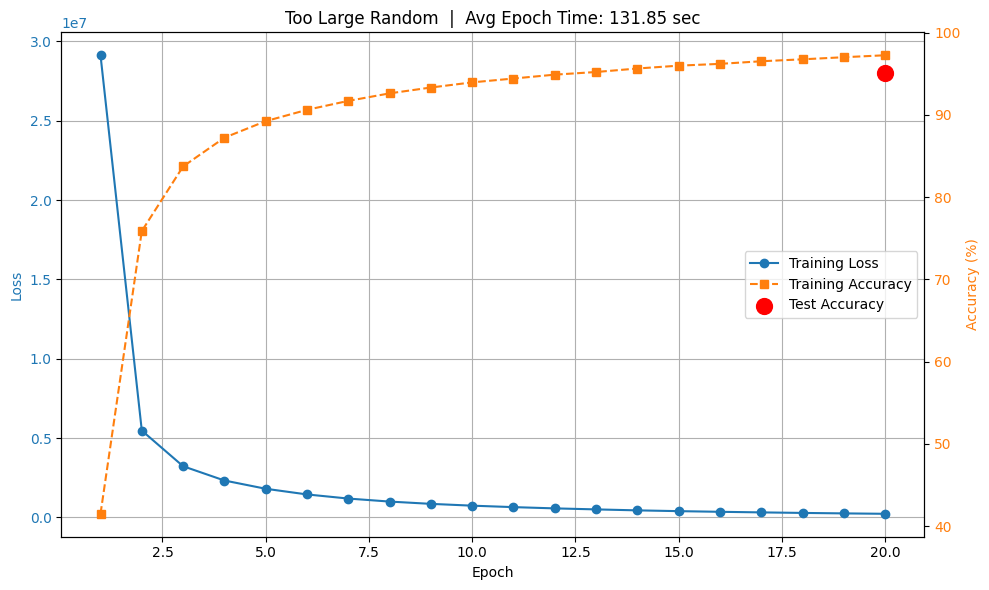

In [26]:
plot_initialization_results(
    results,
    variants_to_plot=["Too Large Random"]
)

The use of **Too Large Random Weights** can be described as **it is like starting on a steep cliff, where the traveler slides quickly, sometimes uncontrollably.** The plot dramatically confirms this chaotic initial state, showing extreme instability and eventual recovery. The **Training Loss** (blue solid line) starts at an enormous value, exceeding **29 million** in Epoch 1. This initial catastrophic loss value is the visual evidence of **exploding gradients** delaying stable learning. Simultaneously, the **Training Accuracy** (orange dashed line) starts low at **41.5%** but then soars almost vertically. Despite the unstable start, the network quickly regained control and accelerated learning: the accuracy reached **89.2% by epoch 5** and **93.95% by epoch 10**, visually confirming the traveler's rapid recovery and descent toward the optimum. By the final epoch, a high training accuracy of **97.25%** was achieved, with the **Test Accuracy** (red marker) closely following at **95.14%**. While the final generalization was good, the initial epochs wasted effort recovering from the extreme loss, making the journey long and risky.

### **Xavier Initialization — The Balanced Plateau**

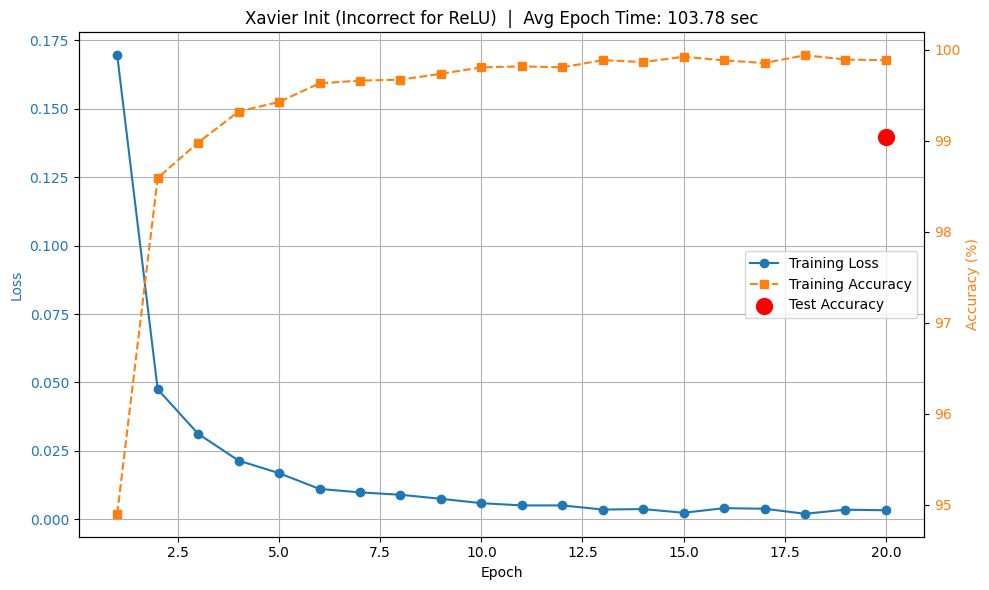

In [27]:
plot_initialization_results(
    results,
    variants_to_plot=["Xavier Init (Incorrect for ReLU)"]
)

The use of **Xavier Initialization (Incorrect for ReLU)** is best described as placing the traveler on a **mathematically leveled plateau**, providing a smooth path that allows exploration without the danger of getting stuck (like **Zero Initialization**) or sliding uncontrollably (like **Too Large Random** initialization).  The plot and detailed results visually confirm this **highly efficient** training regime, immediately overcoming the **cautious and slow climb** seen with the **Too Small Random** method. 

The network demonstrates extremely rapid learning: the **Training Accuracy** (orange dashed line) made a dramatic jump from **94.90% (Epoch 1)** to **99.43% by Epoch 5**, reaching near-maximum performance almost immediately. Correspondingly, the **Training Loss** (blue solid line) shows a **rapid and sustained drop**, plummeting from its initial value of **0.1695** down to **0.0169 by Epoch 5**, stabilizing quickly near the x-axis for the remainder of the training. The network achieved a very high training accuracy of **99.81% by Epoch 10** and sustained this performance, peaking at **99.94% by Epoch 18**. A closer visual inspection shows **subtle, minimal up-and-down movement** in the accuracy curve across the epochs, suggesting a slight **unstable oscillation**. This minor imperfection is expected because **Xavier is theoretically sub-optimal for ReLU** activation functions. Despite this slight instability, the overall training was efficient, taking **103.78 seconds per epoch**. The traveler successfully reached the target quickly without slips or unnecessary caution, leading to **excellent generalizability**, as confirmed by the final **Test Accuracy** of **99.04%** (Test Loss: 0.0496), which sits very close to the peak training accuracy.

### **He Initialization — Energizing Downhill**

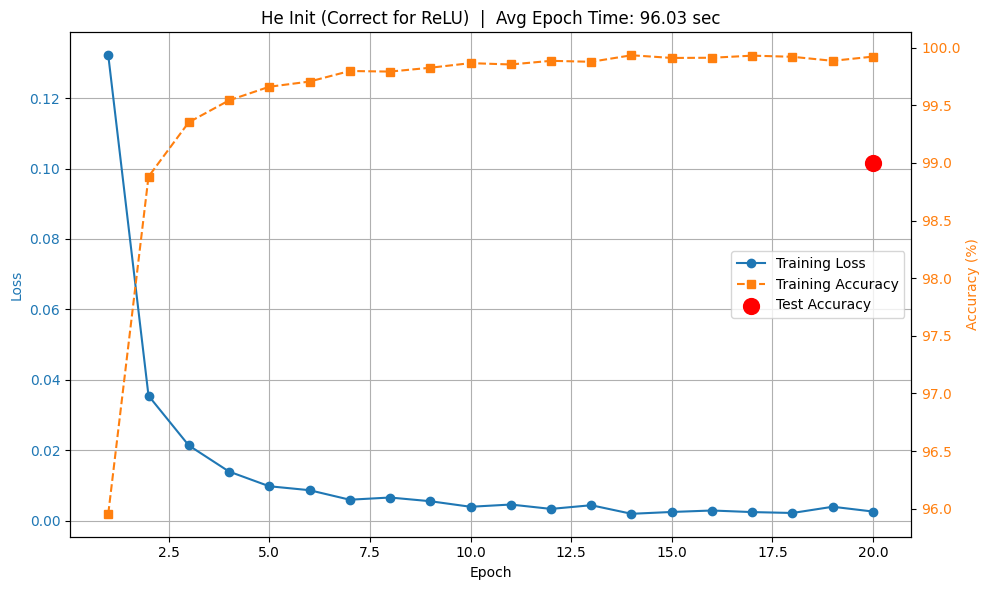

In [28]:
plot_initialization_results(
    results,
    variants_to_plot=["He Init (Correct for ReLU)"]
)

The **He Initialization (Correct for ReLU)** provides the optimal training environment, giving the traveler a **gentle downhill slope**—**just enough momentum to accelerate without losing control.** The plot and results confirm that **He Initialization is superior to Xavier** for this ReLU network.

This method demonstrated **significantly faster and more stable learning** than all previous initializations. The **Training Loss** (blue solid line) began lower than Xavier (0.1322 vs. 0.1695) and reached **99.54% accuracy by Epoch 4** while loss was **0.0140**, beating Xavier's time (Xavier hit 99.43% only by Epoch 5 at 0.0169 loss). This accelerated initial phase demonstrates the **more energized start** given to the traveler. Furthermore, the overall training was more **efficient**, with an **Average Epoch Time of 96.03 seconds**, which is nearly **8 seconds faster per epoch** than Xavier's 103.78 seconds.

The accuracy curve (orange dashed line) shows a rapid, smooth climb that quickly stabilizes near **100%**, confirming that the strong gradients prevented "dead neurons" from slowing learning, a major benefit over "Too Small Random." Training accuracy ultimately peaked at **99.93%**—slightly higher than Xavier's 99.89% peak. Most importantly, the **Training and Test Accuracy curves stayed closely aligned** across the entire plot, resulting in excellent generalizability, with the **Test Accuracy** (red marker) at **99.00%**. He initialization provided the fastest, most predictable, and most efficient path to high performance.

## **Ending the Story: Starting in the Right Place**

| Initialization Method | Analogy | Final Train Accuracy | Avg. Epoch Time (sec) | Summary of Performance |
| :--- | :--- | :--- | :--- | :--- |
| **Zero** | Flat Plateau | 11.24% | 132.34 | **Failure**; Stuck due to symmetry. |
| **Too Small** | Tiny Hills | 94.51% | 130.42 | **Slow**; Reliable but constrained by weak gradients. |
| **Too Large** | Steep Cliff | 97.25% | 131.85 | **Chaotic**; High risk, high instability, eventual recovery. |
| **Xavier** | Leveled Plateau | 99.89% | 103.78 | **Fast**; Highly efficient, but slightly sub-optimal for ReLU. |
| **He** | Gentle Downhill | **99.92%** | **96.03** | **Optimal**; Fastest, most stable, and most efficient. |

The journeys clearly show the influence of weight initialization. Zero and tiny hills constrained movement, steep cliffs created initial chaos, Xavier offered a smooth plateau, and He provided an energizing downhill path. Importantly, He initialization not only achieved faster convergence and high accuracy, but also maintained excellent generalization and stable loss reduction, proving that the theoretical “energized start for ReLU” claim holds true in practice. Choosing the right starting terrain ensures the traveler reaches the destination safely, efficiently, and reliably.

![Alt Text](../Laboratories/assets/weight2.png)

A model’s journey through the loss landscape is long.
Initialization determines whether it starts:

> ***in a valley***

> ***on a cliff***

> ***in a desert***

> ***or on a well-balanced plateau***

Good initialization does not guarantee success —
but bad initialization guarantees failure.

Choosing the right weight initialization acts as the GPS, guiding your model past the traps and straight to the best starting point. <br>
This GPS doesn't walk for you, but it guarantees the fastest, most reliable way to the summit. 

Now, you stand here. The vibrant sunset is the beautiful result of following that guidance. <br>
The learning is complete, the journey is a success, and the model's work is finished.

## **References**

Goyal, C. (2024, February 15). *How to initialize weights in neural networks?* Analytics Vidhya. Retrieved November 19, 2025, from https://www.analyticsvidhya.com/blog/2021/05/how-to-initialize-weights-in-neural-networks/ 

Kashyap, P. (2024, November 2). *Mastering weight initialization in neural networks: A beginner’s guide*. Medium. Retrieved November 19, 2025, from https://medium.com/@piyushkashyap045/mastering-weight-initialization-in-neural-networks-a-beginners-guide-6066403140e9 